# HOMEWORK 1 NEURAL NETWORKS AND DEEP LEARNING

---
A.A. 2021/22 (6 CFU) - Dr. Alberto Testolin, Dr. Umberto Michieli
---
Student: Matteo Grandin
---
id: 2020374

# Regression task

## Initializations

In [403]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")

Training device: cuda


## Dataset

In the following cell I just get the datasets for the regression task, load them, get a sample, and plot the 2 datasets.

--2022-01-03 12:51:34--  https://gitlab.dei.unipd.it/michieli/nnld-2021-22-lab-resources/-/raw/main/homework1/train_data.csv
Resolving gitlab.dei.unipd.it (gitlab.dei.unipd.it)... 147.162.2.85
Connecting to gitlab.dei.unipd.it (gitlab.dei.unipd.it)|147.162.2.85|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3776 (3,7K) [text/plain]
Saving to: ‘regression_dataset/train_data.csv.46’

train_data.csv.46   100%[===================>]   3,69K  --.-KB/s    in 0s      

2022-01-03 12:51:34 (28,7 MB/s) - ‘regression_dataset/train_data.csv.46’ saved [3776/3776]

--2022-01-03 12:51:34--  https://gitlab.dei.unipd.it/michieli/nnld-2021-22-lab-resources/-/raw/main/homework1/test_data.csv
Resolving gitlab.dei.unipd.it (gitlab.dei.unipd.it)... 147.162.2.85
Connecting to gitlab.dei.unipd.it (gitlab.dei.unipd.it)|147.162.2.85|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3788 (3,7K) [text/plain]
Saving to: ‘regression_dataset/test_data.csv.46’

test_

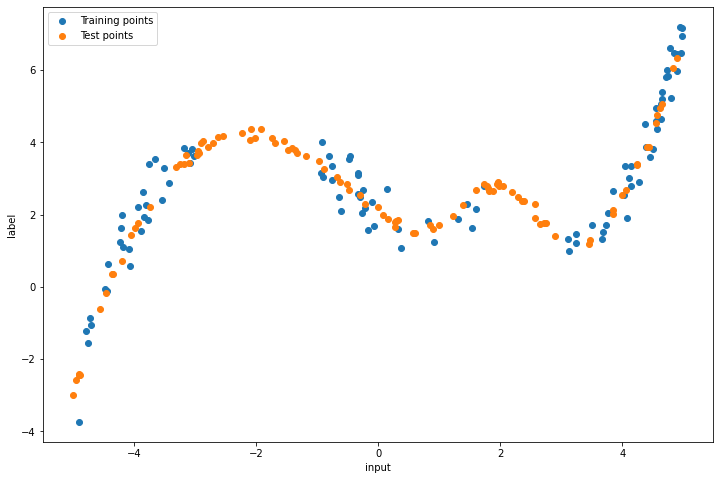

Train set size: 100
Test set size: 100


In [404]:
### Dataset loading
!wget -P regression_dataset https://gitlab.dei.unipd.it/michieli/nnld-2021-22-lab-resources/-/raw/main/homework1/train_data.csv
!wget -P regression_dataset https://gitlab.dei.unipd.it/michieli/nnld-2021-22-lab-resources/-/raw/main/homework1/test_data.csv 

#load the datasets
train_df = pd.read_csv('regression_dataset/train_data.csv')
test_df = pd.read_csv('regression_dataset/test_data.csv')

#plot train (+validation) set
fig = plt.figure(figsize=(12,8))
plt.scatter(train_df.input, train_df.label, label='Training points')
plt.xlabel('input')
plt.ylabel('label')
#plot test set on the same plot
plt.scatter(test_df.input, test_df.label, label='Test points')
plt.legend()
plt.show()

print(f'Train set size: {train_df.shape[0]}')
print(f'Test set size: {test_df.shape[0]}')

#divide the training set into training and validation sets
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(train_df.input, train_df.label, test_size=0.2, random_state=42)

### Train data
with open('train_data.csv', 'w') as f:
    #write the header
    f.write('input,label\n')
    data = [f"{x},{y}" for x, y in zip(x_train, y_train)]
    f.write('\n'.join(data))
    #write footer
    f.write('\n')
    
### Validation data
with open('val_data.csv', 'w') as f:
    #write the header
    f.write('input,label\n')
    data = [f"{x},{y}" for x, y in zip(x_val, y_val)]
    f.write('\n'.join(data))
    #write footer
    f.write('\n')


In [405]:
# Dataset 
class CsvDataset(Dataset):

    def __init__(self, csv_file, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.transform = transform
        # Read the file and split the lines in a list
        with open(csv_file, 'r') as f:
            lines = f.read().split('\n')
        # Get x and y values from each line and append to self.data
        self.data = []
        # remove header and footer
        lines = lines[1:-1]
        for line in lines:
            sample = line.split(',')
            self.data.append((float(sample[0]), float(sample[1])))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Our sample is the element idx of the list self.data
        sample = self.data[idx]
        if self.transform:
            sample = self.transform(sample)
        return sample

# simple pytorch tensor conversion
class ToTensor(object):
    """Convert sample to Tensors."""
    def __call__(self, sample):
        x, y = sample
        return (torch.tensor([x]).float(),
                torch.tensor([y]).float())

composed_transform = transforms.Compose([ToTensor()])

# create the dataset
train_dataset = CsvDataset('train_data.csv', transform=composed_transform)
val_dataset = CsvDataset('val_data.csv', transform=composed_transform)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0) #batch size = 8
val_dataloader  = DataLoader(val_dataset,  batch_size=len(val_dataset), shuffle=False, num_workers=0)

From the plot it's very noticeable that the training points are not sampled in the same way of the test points, for example, around -2 and +2 there are 2 "blank" spots, with no samples whatsoever, moreover the samples in the training set seem to have an higher variance. The model will need to be able to generalize. 

## Neural Network Architecture

Define a fully connected feed-forward network, different architectures will be considered, different activation functions will be considered in the hidden layers, no activation function will be considered for the output layer since we are dealing with a regression problem and we don't want to limit the output.

In [406]:
### @add DROPOUT LAYERS
#basic 2-layer network with 2 hidden layers, sigmoid activation function
class Net(nn.Module):
    
    def __init__(self, Ni, Nh1, Nh2, No, activation_fn = nn.Sigmoid() ,droput_rate=0):
        """
        Ni - Input size
        Nh1 - Neurons in the 1st hidden layer
        Nh2 - Neurons in the 2nd hidden layer
        No - Output size
        """
        super().__init__()
        
        print('Network initialized')
        self.fc1 = nn.Linear(in_features=Ni, out_features=Nh1)
        self.dp1 = nn.Dropout(p=droput_rate)
        self.fc2 = nn.Linear(in_features=Nh1, out_features=Nh2)
        self.dp2 = nn.Dropout(p=droput_rate)
        self.out = nn.Linear(in_features=Nh2, out_features=No)
        self.act = activation_fn
        
    def forward(self, x, additional_out=False):
        x = self.act(self.fc1(x))
        x = self.act(self.fc2(x))
        x = self.out(x)
        # x = self.act(self.fc1(x)) ##original
        # x = self.act(self.fc2(x)) ##original
        # x = self.out(x)           ##original
        return x

## Training

In [407]:
## Perform cross validation, best way is to use k-fold cross validation. Best model is retrained later.

In [408]:
### TRAINING FUNCTION
def train_model(net, train_dataloader, val_dataloader, optimizer, loss_fn, num_epochs=1, enable_early_stopping=True):
    print('Training started')
    net = net.to(device)
    train_loss_log = []
    val_loss_log = []
    min_validation_loss = float('inf')
    early_stopping_counter = 0
    for epoch_num in tqdm(range(num_epochs)):

        ### TRAIN
        train_loss= []
        net.train() # Training mode (e.g. enable dropout, batchnorm updates,...)
        for sample_batched in train_dataloader:
            # Move data to device
            x_batch = sample_batched[0].to(device)
            label_batch = sample_batched[1].to(device)

            # Forward pass
            out = net(x_batch)

            # Compute loss
            loss = loss_fn(out, label_batch)

            # Backpropagation
            net.zero_grad() # Zero the gradients
            loss.backward() # Compute the gradients

            # Update the weights
            optimizer.step()

            # Save train loss for this batch
            loss_batch = loss.detach().cpu().numpy()  # .detach() to avoid keeping the gradient in memory
            train_loss.append(loss_batch)

        # Save average train loss
        train_loss = np.mean(train_loss)
        # print(f'Train loss: {train_loss}')
        train_loss_log.append(train_loss)

        ### VALIDATION
        val_loss= []
        net.eval() # Evaluation mode (e.g. disable dropout, batchnorm,...)
        with torch.no_grad(): # Disable gradient tracking
            for sample_batched in val_dataloader:
                # Move data to device
                x_batch = sample_batched[0].to(device)
                label_batch = sample_batched[1].to(device)

                # Forward pass
                out = net(x_batch)

                # Compute loss
                loss = loss_fn(out, label_batch)

                # Save val loss for this batch
                loss_batch = loss.detach().cpu().numpy()
                val_loss.append(loss_batch)

            # Save average validation loss
            val_loss = np.mean(val_loss)
            # print(f"AVERAGE VAL LOSS: {np.mean(val_loss)}")
            val_loss_log.append(val_loss)

            ## early stopping
            if enable_early_stopping:
                if val_loss < min_validation_loss:
                    min_validation_loss = val_loss
                    torch.save(net.state_dict(), 'training/best_regression_val_model.pt')
                if epoch_num > 10 and np.mean(val_loss_log[-3:-1]) > 1.2*min_validation_loss:
                    early_stopping_counter += 1
                    if early_stopping_counter > 5:
                        early_stopping_counter += 1
                        print("Early stopping")
                        #load previous best model
                        net.load_state_dict(torch.load('training/best_regression_val_model.pt'))
                        break
                else:
                    early_stopping_counter = 0
                
    return train_loss_log, val_loss_log, net

In [409]:
## TRAINING
torch.manual_seed(42)
net = Net(1, 16, 16, 1, activation_fn=nn.Tanh(),droput_rate=0)
act_fns = [nn.Sigmoid(), nn.Tanh(), nn.ReLU(), nn.Softsign(), nn.Softplus()]
hidden_layers = [16, 32, 64]
# Define the loss function
loss_fn = nn.MSELoss()
loss_fns = [nn.L1Loss(), nn.HuberLoss(), nn.MSELoss()]
# Define the optimizer
optimizer = optim.Adam(net.parameters(), lr=5e-3)
optimizers = [optim.SGD(net.parameters(), lr=5e-3), optim.Adam(net.parameters(), lr=5e-3), optim.RMSprop(net.parameters(), lr=5e-3)]
lr_rates = [15e-3, 10e-3, 8e-3, 5e-3, 2e-3, 1e-3, 5e-4]
num_epochs = 1500 
# Train
train_loss_log, val_loss_log, net = train_model(net, train_dataloader, val_dataloader, optimizer, loss_fn, num_epochs, enable_early_stopping=False)

Network initialized
Training started


100%|██████████| 1500/1500 [00:11<00:00, 132.87it/s]


# Notes
- using a big batch size (256), and training for a lot of epochs the model overfits, I therefore implemented early stopping in order to stop the training when the validation loss exceeds 20% of the minimum validation loss so far
- using a big batch size is not effective (with adam at least), it's better to use small batch sizes to achieve faster convergence
- I achieved very good results with 11k iterations (early stopped) 256 bs. lr 1e-3 adam mse. 
- Droput is very bad in this situation (why?)
- L1Loss works very well, much better than MSE, but needs more iterations
- HuberLoss also works well, but also needs more iterations

Optimizers:
- Adam is good lr around 5e-3, lower if we do more iterations
- SGD with momentum needs higher lr, 
- SGD without momentum bad
- RMSprop similar to Adam but slightly worse

Activation functions
- Relu is not smooth and it's not correct for this smooth function
- Tanh and Sigmoid give similar results, Tanh slightly better
- Softsign similar to Tanh but worse
- nn.Softplus() kinda good
- Softshrink a kinda smoother relu but still worse

Number of hidden layers
- 16/32 is a good number
- the bigger the number the faster the convergence, but the higher the risk of overfitting

### Plot losses

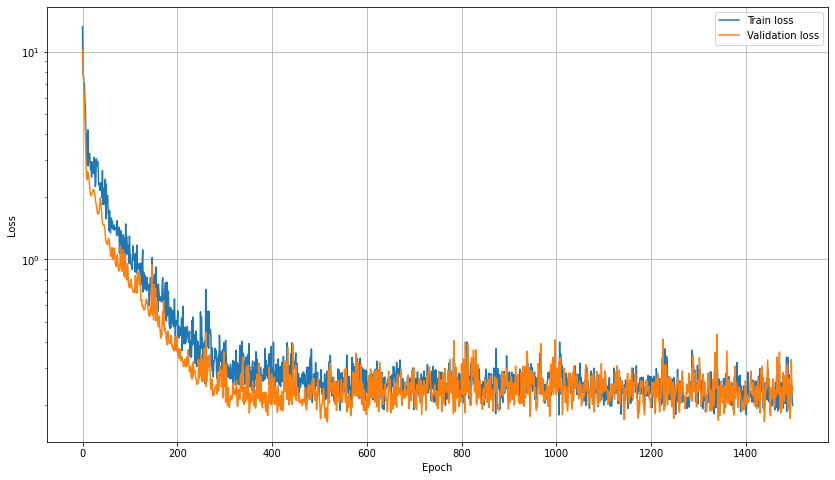

In [410]:
# Plot losses
plt.figure(figsize=(14,8))
plt.semilogy(train_loss_log, label='Train loss')
plt.semilogy(val_loss_log, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

## Network analysis

In [411]:
## @add You need to visualize Weight histograms, activation profiles, and the final output of the network.

### Network output

In [412]:
# Input vector
x_vec = torch.linspace(-5,5,1000)
x_vec = x_vec.to(device)
x_vec = x_vec.unsqueeze(-1)  # Adding a dimension to the input vector
print(f"Input shape: {x_vec.shape}")

net.eval()
with torch.no_grad(): # turn off gradients computation
    y_vec = net(x_vec)
print(f"Output shape: {y_vec.shape}")


Input shape: torch.Size([1000, 1])
Output shape: torch.Size([1000, 1])


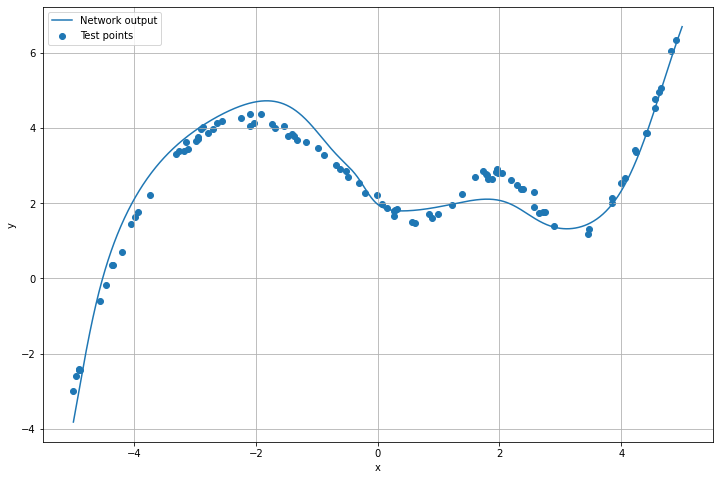

In [413]:
# Convert x_vec and y_vec to numpy one dimensional arrays
x_vec = x_vec.squeeze().cpu().numpy()
y_vec = y_vec.squeeze().cpu().numpy()

# Plot output
plt.figure(figsize=(12,8))
plt.plot(x_vec, y_vec, label='Network output')
#show the points from the test dataset
plt.scatter(test_df.input, test_df.label, label='Test points')

#plt.plot(x_vec, true_model, label='True model')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.legend()
plt.show()

## Implement more stuff!!!!!!!!!!!
Need to develop: advance optimizers and regularization methods (initialization scheme, momentum, ADAM, early stopping, L1, L2, sparsity dropuut)

Also hyperparameters tuning is required, like learning rate (see if there are others)